# Bilderzeugung mit VAE

**Original Author:** [fchollet](https://twitter.com/fchollet)<br>
**Translated and Modified and Curated by:** Volker Göhler<br>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Autoencoder Source view on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/SchuelerUniTUBAF2024/blob/main/03_Bilderzeugung_mit_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/vgoehler/SchuelerUniTUBAF2024/blob/main/03_Bilderzeugung_mit_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [5]:
#!pip install --upgrade tensorflow
#!pip install --upgrade keras

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Sequential

def plot_acc_val(history_dict):

    def plot_subplot(type, axis, color, train):
        axis.plot(epochs, train, '%s'%color, label='Training %s'%type)
        axis.set_title("Training %s"%type)
        axis.set_xlabel('Epochs')
        axis.set_ylabel(type.capitalize())
        axis.legend()
    
    loss = history_dict['loss']
    rec_loss = history_dict["reconstruction_loss"]
    kl_loss = history_dict["kl_loss"]
    accuracy = history_dict.get('accuracy', history_dict.get('acc'))
    epochs = range(1, len(loss) + 1)

    # Creating subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))

    # Plotting the training loss
    plot_subplot('loss', ax1, 'g', loss)
    plot_subplot('reconstruction_loss', ax2, 'y', rec_loss)
    plot_subplot('kl_loss', ax3, 'b', kl_loss)    


    plt.tight_layout()
    plt.show()

2025-08-01 12:45:07.927485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 12:45:07.939960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 12:45:07.943549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 12:45:07.953196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Variational Autoencoder

<table>
  <tr><td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png"
         alt="Variational Autoencoder by EugenioTL, CC BA-SA 4.0" width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Abbildung 1.</b>Variational Autoencoder by EugenioTL, CC BA-SA 4.0<br/>&nbsp;
  </td></tr>
</table>


## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

I0000 00:00:1754045116.645098  167286 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754045116.691756  167286 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754045116.694623  167286 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754045116.698071  167286 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

### Load Training Dataset
Laden wir den Fashion MNIST-Datensatz, skalieren ihn und teilen ihn in einen Trainingssatz, einen Validierungssatz und einen Testsatz auf.
Der [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)-Datensatz enthält 70.000 Graustufenbilder in 10 Kategorien. Die Bilder zeigen einzelne Kleidungsstücke in niedriger Auflösung (28 mal 28 Pixel), wie hier zu sehen:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Abbildung 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST-Beispiele</a> (von Zalando, MIT-Lizenz).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST ist als direkter Ersatz für den klassischen [MNIST](http://yann.lecun.com/exdb/mnist/)-Datensatz gedacht, der oft als „Hello World“ für maschinelle Lernprogramme in der Computer Vision verwendet wird. Der MNIST-Datensatz enthält Bilder von handschriftlichen Ziffern (0, 1, 2 usw.) in einem Format, das identisch zu dem der hier verwendeten Kleidungsstücke ist.

In [6]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

mnist_fashion = np.concatenate([x_train, x_test], axis=0)
mnist_fashion = np.expand_dims(mnist_fashion, -1).astype("float32") / 255.


Epoch 1/30


I0000 00:00:1754045135.292706  167356 service.cc:146] XLA service 0x71be78007620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754045135.292734  167356 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-08-01 12:45:35.336482: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-01 12:45:35.545008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 42/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 0.0747 - loss: 514.8073 - reconstruction_loss: 512.2660

I0000 00:00:1754045138.954355  167356 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - kl_loss: 3.9333 - loss: 389.2084 - reconstruction_loss: 385.2750
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.8317 - loss: 287.3917 - reconstruction_loss: 279.5602
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.2558 - loss: 278.5529 - reconstruction_loss: 271.2971
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.0938 - loss: 274.5444 - reconstruction_loss: 267.4506
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.0036 - loss: 272.4642 - reconstruction_loss: 265.4607
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 6.9583 - loss: 271.6500 - reconstruction_loss: 264.6916
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 6.9212 - loss: 270.0060 - reconstruction_loss: 263.0848
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 6.8865 - loss: 269.5688 - reconstruction_loss: 262.6822
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_l

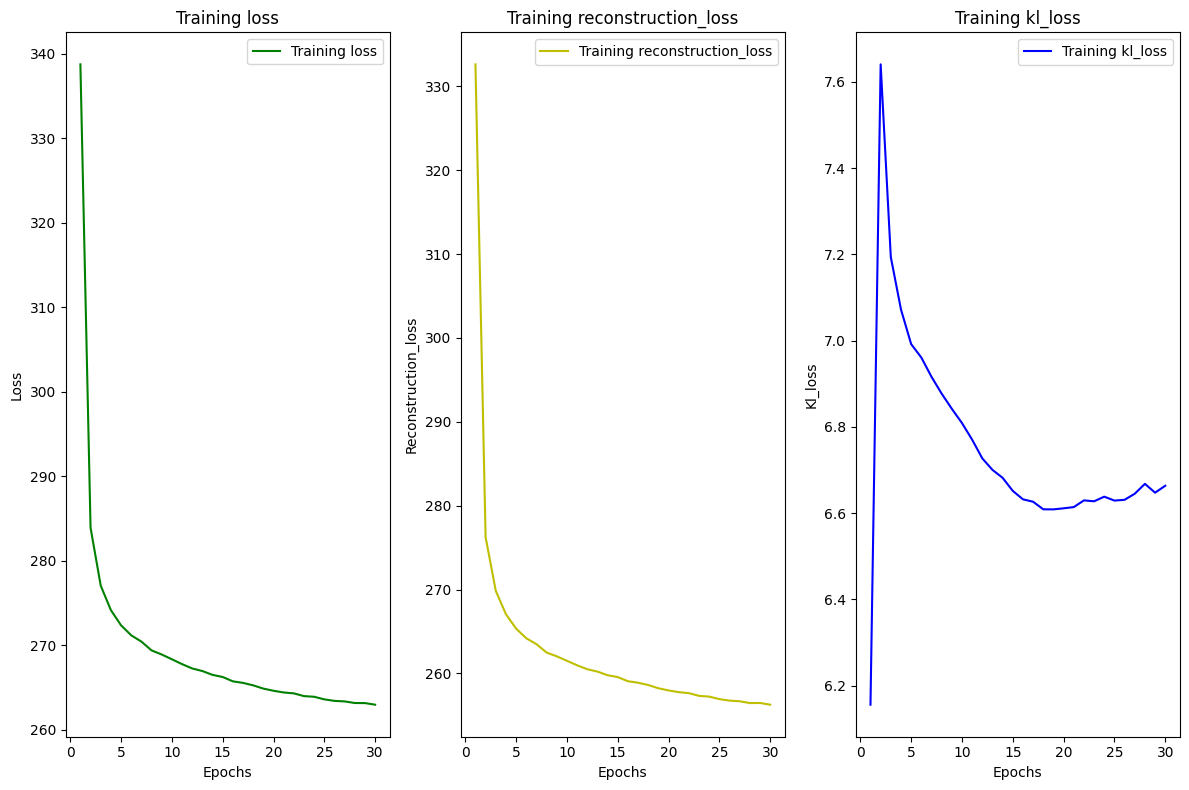

In [7]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history_vae = vae.fit(mnist_fashion, epochs=30, batch_size=128)

plot_acc_val(history_vae.history)

## Display a grid of sampled digits

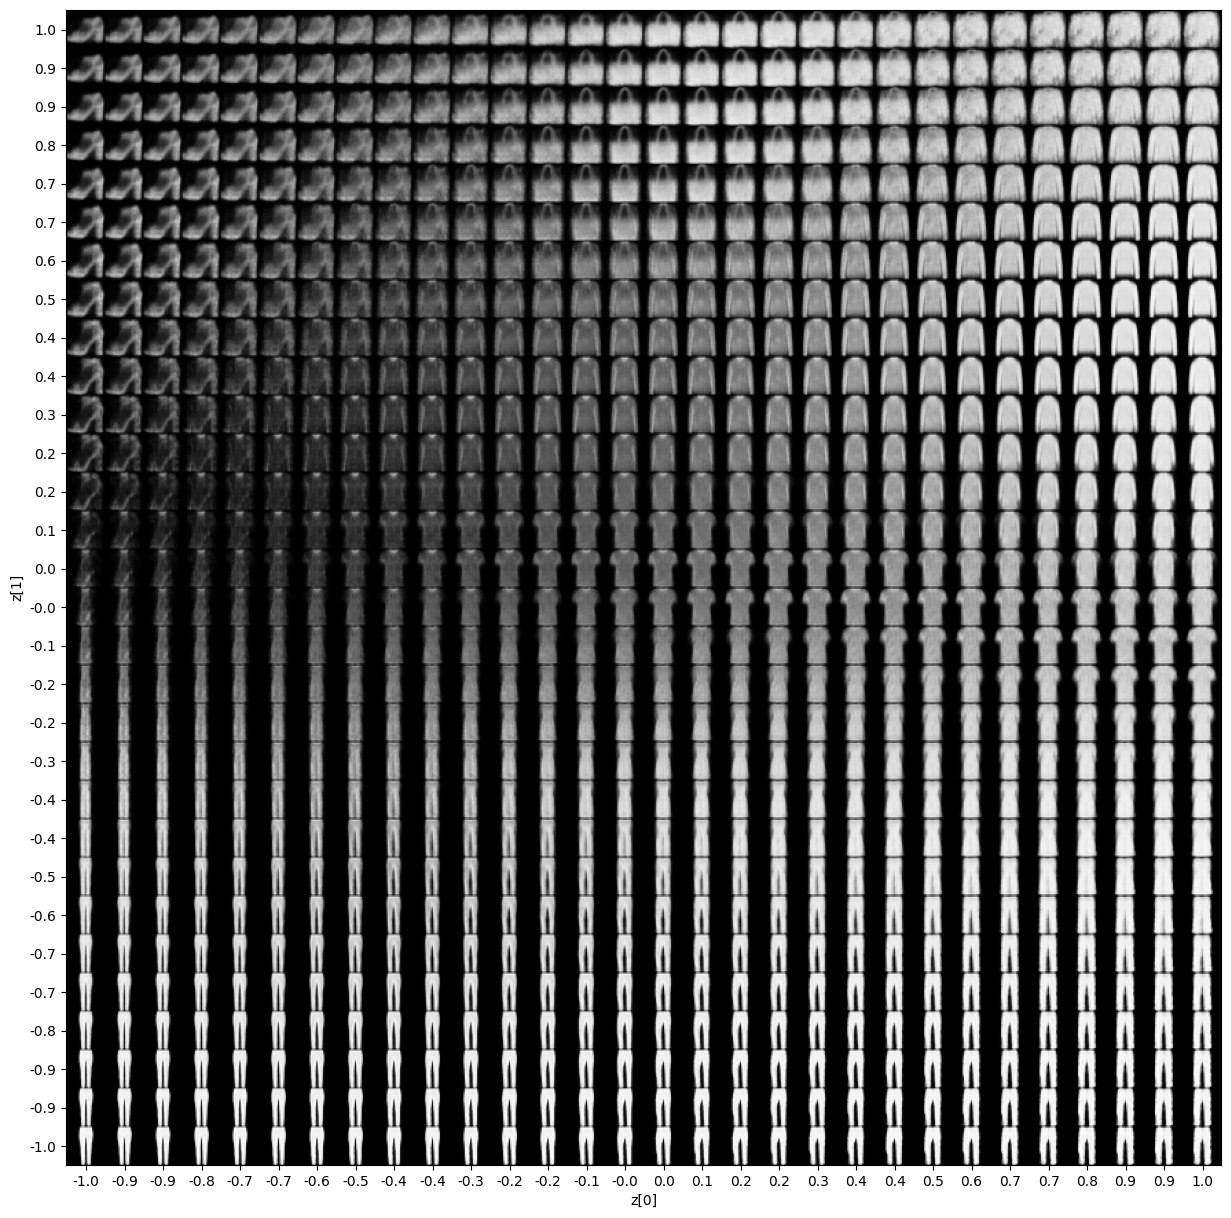

In [8]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

### Reconstruction

In [9]:
codings = tf.random.normal(shape=[5 * 10, latent_dim])
images = decoder(codings).numpy()

W0000 00:00:1754045238.648335  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.662723  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.663389  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.664005  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.665913  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.666540  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.667151  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.667722  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045238.668319  167286 gp

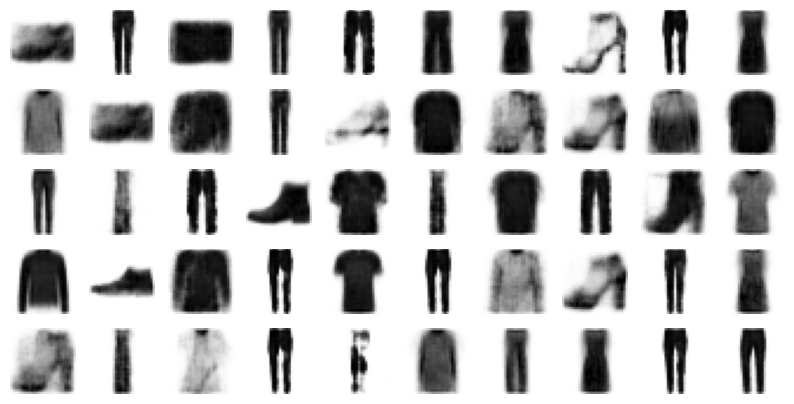

In [10]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 10)
plt.show()

## Die Blumenaufgabe

Nutzt den VAE um Blumen zu rekonstruieren.
Mögliche Verbesserungen sind:

    - Farbe zu verwenden (colormode='rgb'), aber ihr braucht dann 3 Outputkanäle.
    - Die Bildgröße anzupassen, aber encoder input und decode output müssen gleiche dimensionen aufweisen
    - die Größe der Latent Dimensions
    - Epochs


In [11]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [12]:
image_width = 28
image_height = 28
batch_size = 32

flowers = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=23,
  image_size= (image_height, image_width),
  label_mode=None,
  batch_size=batch_size,
  color_mode='grayscale')

Found 7340 files.


2025-08-01 12:47:43.698460: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


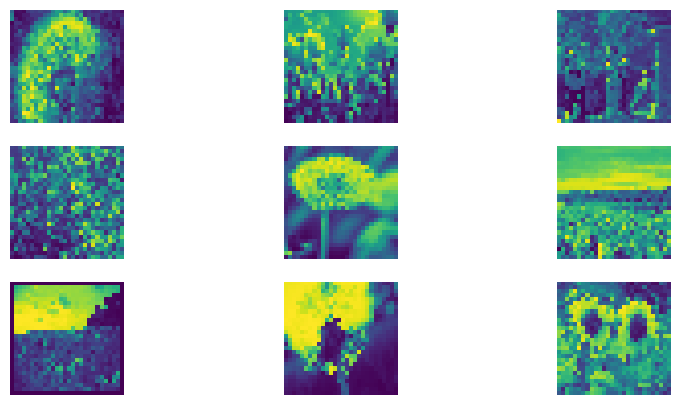

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images in flowers.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

flowers = flowers.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Normalize

In [15]:
from keras.layers import Rescaling

normalization_layer = Rescaling(1./255)

flowers_ds_norm = flowers.map(lambda x: (normalization_layer(x)))


### Build our Autoencoder
#### Encoder

In [16]:
latent_dim_fl = 2

encoder_inputs = keras.Input(shape=(image_width, image_height, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim_fl, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim_fl, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder_fl = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_fl.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     50,192 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

#### Decoder

In [17]:
min_width=7
min_height=7

latent_inputs_fl = keras.Input(shape=(latent_dim_fl,))
x = layers.Dense(min_width * min_height * 64, activation="relu")(latent_inputs_fl)
x = layers.Reshape((min_width, min_height, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs_fl = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_fl = keras.Model(latent_inputs_fl, decoder_outputs_fl, name="decoder")
decoder_fl.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 1.0473 - loss: 528.9440 - reconstruction_loss: 527.8969
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 3.4379 - loss: 514.1874 - reconstruction_loss: 510.7496
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.2966 - loss: 510.8960 - reconstruction_loss: 507.5994
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.1304 - loss: 508.2167 - reconstruction_loss: 505.0862
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.8742 - loss: 507.6175 - reconstruction_loss: 504.7434
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.7792 - loss: 507.1187 - reconstruction_loss: 504.3394
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.6351 - loss: 505.5832 - reconstruction_loss: 502.9481
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.6383 - loss: 505.2908 - reconstruction_loss: 502.6524
Epoch 9/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

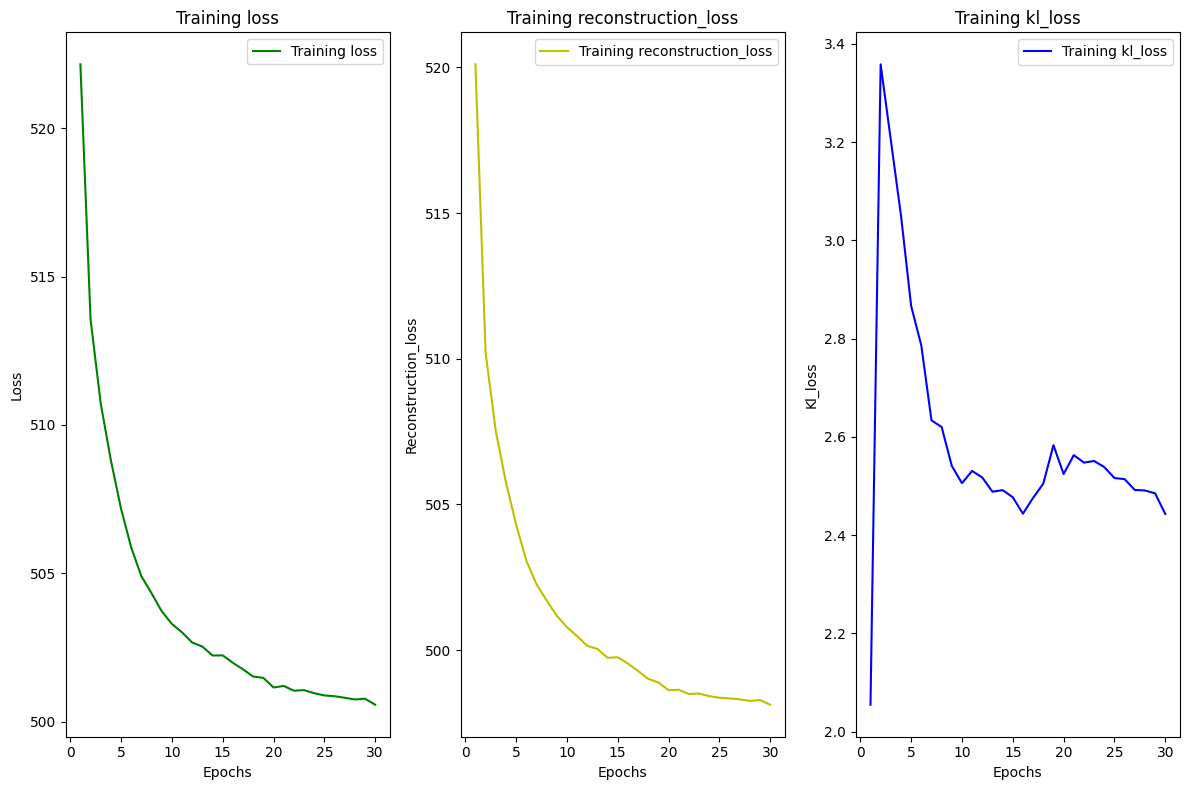

In [18]:
# RESET
tf.keras.backend.clear_session()

epochs = 30

flower_vae = VAE(encoder_fl, decoder_fl)
flower_vae.compile(optimizer=keras.optimizers.Adam())
history_flower = flower_vae.fit(flowers_ds_norm, epochs=epochs, batch_size=batch_size)

plot_acc_val(history_flower.history)

#### Reconstruction

W0000 00:00:1754045297.771544  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.772131  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.772688  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.773247  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.773813  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.774363  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.774930  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.775485  167286 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1754045297.776059  167286 gp

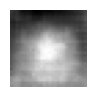

In [19]:
codings = tf.random.normal(shape=[1 * 1, latent_dim_fl])
images = decoder_fl(codings).numpy()

plot_multiple_images(images, 1)
plt.show()